# Intro: Linear Regression — Closed-form equations vs Gradient Descent 
We are going to work with the [California housing dataset](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_california_housing.html).

First step will be a simple regression between and median income and median house value (target)

Ordinary Least Squares (OLS) Linear Regression

In ONL, we want to find the line (or hyperplane) that minimizes the vertical offsets. Hence, we define the best-fitting line as the line that minimizes the sum of squared errors (SSE) or mean squared error (MSE) between our target variable (y) and our predicted output over all samples i in our dataset of size n.

![title](images/ols.png)
Image from https://sebastianraschka.com/

$SSE=\sum_i(target^{(i)} - outpput^{(i)})^2$

$MSE=\frac{1}{n}\times{SSE}$

We ae going to implement a linear regression model for performing OLS regression using the following approaches:

1. Solving the model parameters analytically (closed-form equations)
2. Using an optimization algorithm (Gradient Descent, Stochastic Gradient Descent, Newton’s Method, Simplex Method, etc.)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.metrics import mean_squared_error

sns.set()  # for plot styling
plt.style.use("classic")
pd.options.mode.chained_assignment = None

In [2]:
cal_housing = fetch_california_housing()
dataset_df = pd.DataFrame(cal_housing.data, columns=cal_housing.feature_names)
dataset_df["Target"] = cal_housing.target

In [3]:
dataset_df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


## Preprocessing

### Check outliers

#### Box plots
Draw box plot for MedInc and Target to identify outliers

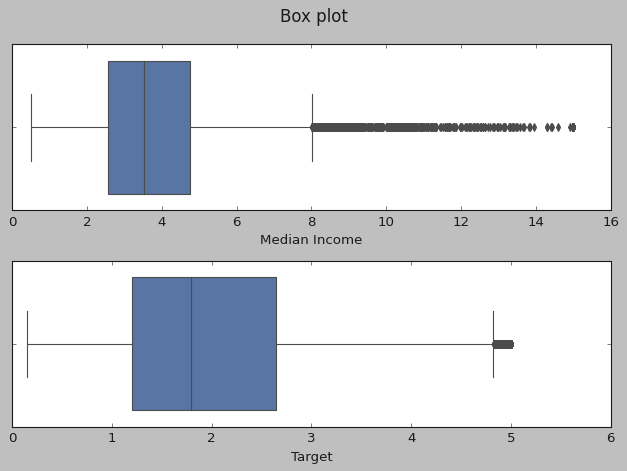

In [4]:
# Generate main figure
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
fig.suptitle("Box plot", fontsize=15)

# Generate plots
sns.boxplot(x="MedInc", data=dataset_df, ax=ax[0])
ax[0].set_xlabel("Median Income")
sns.boxplot(x="Target", data=dataset_df, ax=ax[1])

# Tweak style (optional)
plt.tight_layout()

#### Distribution plots
Now try [jointplot](https://seaborn.pydata.org/generated/seaborn.jointplot.html) from seaborn

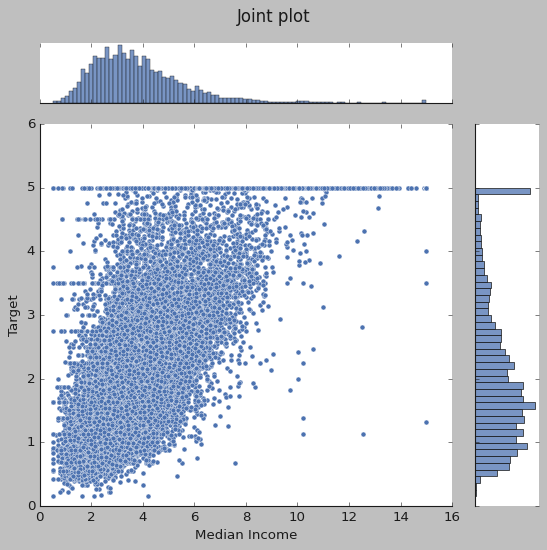

In [5]:
# Generate plot
plot = sns.jointplot(x="MedInc", y="Target", data=dataset_df, height=7)
plot.ax_joint.set_xlabel("Median Income")
plot.fig.suptitle("Joint plot", fontsize=15)

# Tweak style (optional)
plt.tight_layout()

#### DataFrame describe()
Also describe method from dataframe can be exploited to look for outliers

In [6]:
# Generate descriptive statistics
dataset_df[["MedInc", "Target"]].describe()

,MedInc,Target
count,20640.000000,20640.000000
mean,3.870671,2.068558
std,1.899822,1.153956
min,0.499900,0.149990
25%,2.563400,1.196000
50%,3.534800,1.797000
75%,4.743250,2.647250
max,15.000100,5.000010


### Removing outliers: Interquartile Range Method (IQR)
A good statistic for summarizing a non-Gaussian distribution sample of data is the <u>Interquartile Range (IQR)</u>.

The IQR is calculated as the difference between the 75th and the 25th percentiles of the data and defines the box in a box and whisker plot.

    Statistics-based outlier detection techniques assume that the normal data points would appear in high probability regions of a stochastic model, while outliers would occur in the low probability regions of a stochastic model.

    Ilyas, Ihab F., and Xu Chu. Data cleaning. ACM, 2019, page 12.

The IQR can be used to identify outliers by defining limits on the sample values that are a factor k of the IQR below the 25th percentile or above the 75th percentile. The common value for the factor k is the value 1.5. A factor k of 3 or more can be used to identify values that are extreme outliers or “far outs” when described in the context of box and whisker plots.

#### Find outliers
Find ouliers using IQR

In [7]:
# Create a support column for counting outliers
dataset_df["Outlier"] = False

# For each column of interest
for col in ["MedInc", "Target"]:
    # Compute the Interquartile Range (IQR)
    q1 = dataset_df[col].quantile(0.25)
    q3 = dataset_df[col].quantile(0.75)
    iqr = q3 - q1

    # Compute the IQR interval for detecting outliers
    low, up = q1 - iqr * 1.5, q3 + iqr * 1.5
    print("\"" + col + "\"" + " IQR interval:\n[" + "{:.2f}".format(low) + ", " + "{:.2f}".format(up) + "]\n")

    # If values are outside the IQR interval, mark them as outliers
    dataset_df.loc[(dataset_df[col] <= low) | (dataset_df[col] >= up), "Outlier"] = True

# Get outliers and inliers
outliers_iqr = dataset_df[dataset_df["Outlier"] == True]
inliers_iqr = dataset_df[dataset_df["Outlier"] == False]

# Print results
print("Total samples: " + str(len(dataset_df)))
print("- Outliers: " + str(len(outliers_iqr)))
print("- Inliers: " + str(len(inliers_iqr)))

# Delete previously created support column
dataset_df.drop("Outlier", inplace=True, axis=1)
outliers_iqr.drop("Outlier", inplace=True, axis=1)
inliers_iqr.drop("Outlier", inplace=True, axis=1)

"MedInc" IQR interval:
[-0.71, 8.01]

"Target" IQR interval:
[-0.98, 4.82]

Total samples: 20640
- Outliers: 1298
- Inliers: 19342


#### See outliers distribution
Plot an hist for outliers distributions

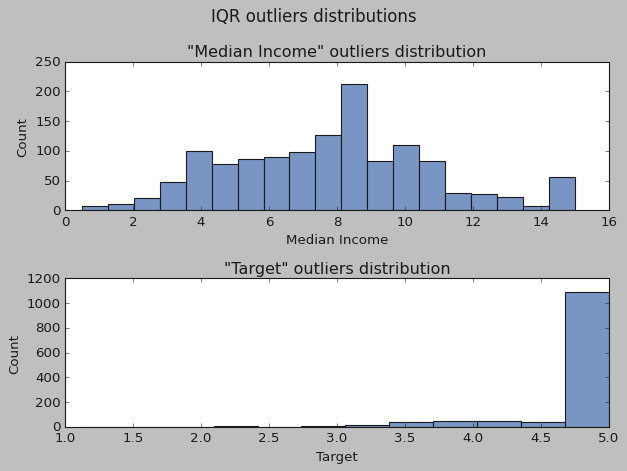

In [8]:
# Round "Target" column values to speed-up plot generation
outliers_iqr = outliers_iqr.round({"Target": 3})

# Generate main figure
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
fig.suptitle("IQR outliers distributions", fontsize=15)

# Generate plots
sns.histplot(x="MedInc", data=outliers_iqr, ax=ax[0])
ax[0].set_xlabel("Median Income")
ax[0].set_title("\"Median Income\" outliers distribution")
sns.histplot(x="Target", data=outliers_iqr, ax=ax[1])
ax[1].set_title("\"Target\" outliers distribution")

# Tweak style (optional)
plt.tight_layout()

### Removing outliers: Automatic Outlier Detection
A simple approach to identifying outliers is to locate those examples that are far from the other examples in the feature space.

This can work well for feature spaces with low dimensionality (few features), although it can become less reliable as the number of features is increased, referred to as the curse of dimensionality.

The <u>local outlier factor</u> (LOF), is a technique that attempts to harness the idea of nearest neighbors for outlier detection. Each example is assigned a scoring of how isolated or how likely it is to be outliers based on the size of its local neighborhood. Those examples with the largest score are more likely to be outliers.

    Breunig, Markus M., et al. "LOF: identifying density-based local outliers." Proceedings of the 2000 ACM SIGMOD international conference on Management of data. 2000.
    
The scikit-learn library provides an implementation of this approach in the [LocalOutlierFactor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html) class.

#### Find outliers
Try LocalOutlierFactor

In [9]:
# Import necessary packages
from sklearn.neighbors import LocalOutlierFactor

# Fit the model and return the labels
is_inlier = LocalOutlierFactor().fit_predict(dataset_df[["MedInc", "Target"]])

# Get outliers and inliers
outliers_lof = dataset_df[is_inlier == -1]
inliers_lof = dataset_df[is_inlier == 1]

# Print results
print("Total samples: " + str(len(dataset_df)))
print("- Outliers: " + str(len(outliers_lof)))
print("- Inliers: " + str(len(inliers_lof)))

Total samples: 20640
- Outliers: 153
- Inliers: 20487


#### See outliers distribution
Plot an hist for outliers distributions

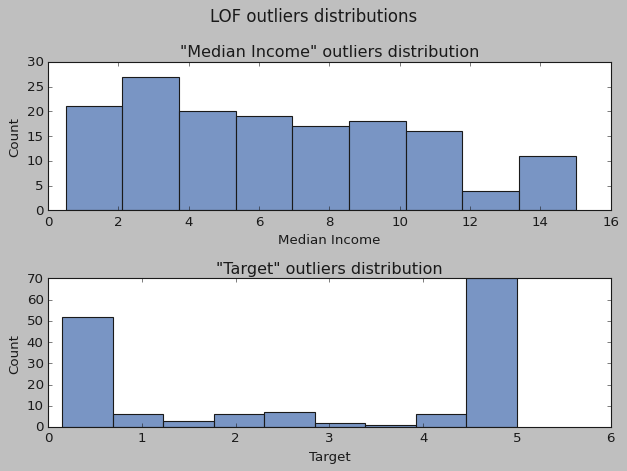

In [10]:
# Generate main figure
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
fig.suptitle("LOF outliers distributions", fontsize=15)

# Generate plots
sns.histplot(x="MedInc", data=outliers_lof, ax=ax[0])
ax[0].set_xlabel("Median Income")
ax[0].set_title("\"Median Income\" outliers distribution")
sns.histplot(x="Target", data=outliers_lof, ax=ax[1])
ax[1].set_title("\"Target\" outliers distribution")

# Tweak style (optional)
plt.tight_layout()

### MinMaxScaler
Scale <u>inliers<u/> using [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [11]:
# Import necessary packages
from sklearn.preprocessing import MinMaxScaler

# Get scaled IQR inliers as a dataframe
inliers_iqr_scaled = pd.DataFrame(MinMaxScaler().fit_transform(inliers_iqr), columns=inliers_iqr.columns)

# Print dataframe preview
inliers_iqr_scaled.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,0.899633,1.0,0.056513,0.021940,0.013818,0.003522,0.564293,0.210159,0.721533
1,0.684719,1.0,0.037750,0.021929,0.015555,0.003098,0.564293,0.209163,0.698417
2,0.445496,1.0,0.041277,0.022166,0.015752,0.002486,0.564293,0.209163,0.700343
3,0.470871,1.0,0.029733,0.022835,0.011491,0.002417,0.564293,0.209163,0.545164
4,0.420587,1.0,0.031026,0.018321,0.030578,0.002397,0.563231,0.209163,0.608306


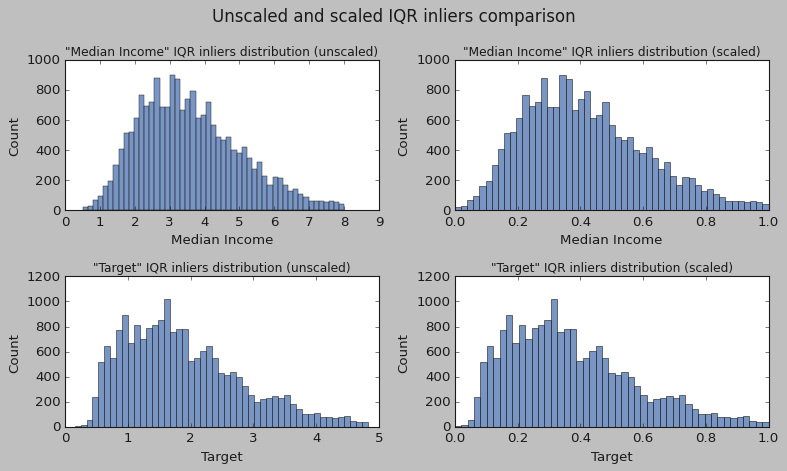

In [12]:
# Generate main figure
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle("Unscaled and scaled IQR inliers comparison", fontsize=15)

# Generate unscaled plots
sns.histplot(x="MedInc", data=inliers_iqr, ax=ax[0][0])
ax[0][0].set_xlabel("Median Income")
ax[0][0].set_title("\"Median Income\" IQR inliers distribution (unscaled)", fontsize=11)
sns.histplot(x="Target", data=inliers_iqr, ax=ax[1][0])
ax[1][0].set_title("\"Target\" IQR inliers distribution (unscaled)", fontsize=11)

# Generate scaled plots
sns.histplot(x="MedInc", data=inliers_iqr_scaled, ax=ax[0][1])
ax[0][1].set_xlabel("Median Income")
ax[0][1].set_title("\"Median Income\" IQR inliers distribution (scaled)", fontsize=11)
sns.histplot(x="Target", data=inliers_iqr_scaled, ax=ax[1][1])
ax[1][1].set_title("\"Target\" IQR inliers distribution (scaled)", fontsize=11)

# Tweak style (optional)
plt.tight_layout()

In [13]:
# Import necessary packages
from sklearn.preprocessing import MinMaxScaler

# Get scaled LOF inliers as a dataframe
inliers_lof_scaled = pd.DataFrame(MinMaxScaler().fit_transform(inliers_lof), columns=inliers_lof.columns)

# Print dataframe preview
inliers_lof_scaled.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,Target
0,0.539668,0.784314,0.043512,0.020469,0.008941,0.003713,0.567481,0.211155,0.898238
1,0.538027,0.392157,0.038224,0.018929,0.067210,0.002825,0.565356,0.212151,0.696220
2,0.466028,1.000000,0.052756,0.021940,0.013818,0.004205,0.564293,0.210159,0.682480
3,0.354699,1.000000,0.035241,0.021929,0.015555,0.003698,0.564293,0.209163,0.659294
4,0.230776,1.000000,0.038534,0.022166,0.015752,0.002968,0.564293,0.209163,0.661227


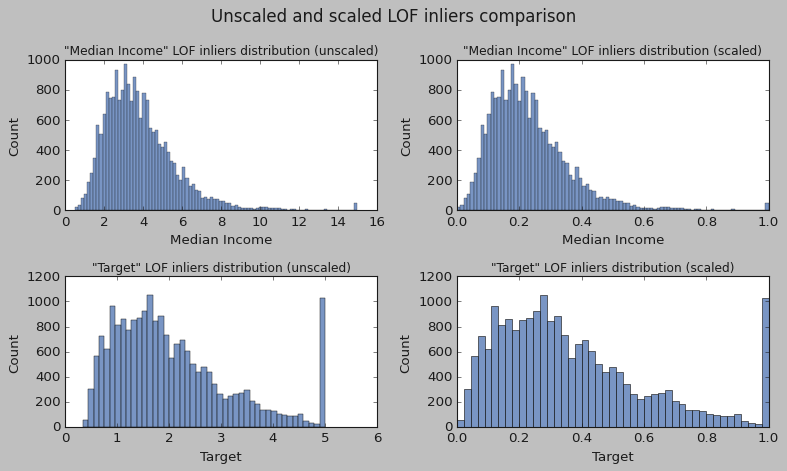

In [14]:
# Generate main figure
fig, ax = plt.subplots(2, 2, figsize=(10, 6))
fig.suptitle("Unscaled and scaled LOF inliers comparison", fontsize=15)

# Generate unscaled plots
sns.histplot(x="MedInc", data=inliers_lof, ax=ax[0][0])
ax[0][0].set_xlabel("Median Income")
ax[0][0].set_title("\"Median Income\" LOF inliers distribution (unscaled)", fontsize=11)
sns.histplot(x="Target", data=inliers_lof, ax=ax[1][0])
ax[1][0].set_title("\"Target\" LOF inliers distribution (unscaled)", fontsize=11)

# Generate scaled plots
sns.histplot(x="MedInc", data=inliers_lof_scaled, ax=ax[0][1])
ax[0][1].set_xlabel("Median Income")
ax[0][1].set_title("\"Median Income\" LOF inliers distribution (scaled)", fontsize=11)
sns.histplot(x="Target", data=inliers_lof_scaled, ax=ax[1][1])
ax[1][1].set_title("\"Target\" LOF inliers distribution (scaled)", fontsize=11)

# Tweak style (optional)
plt.tight_layout()

### See correlation between MedInc and Target
Exploit .corr() method of pd dataframes

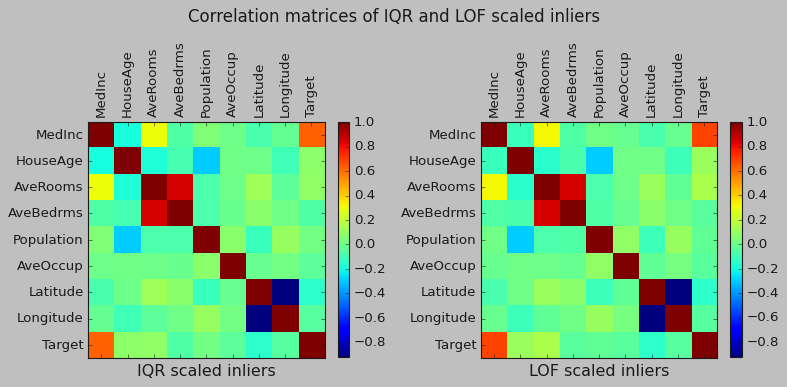

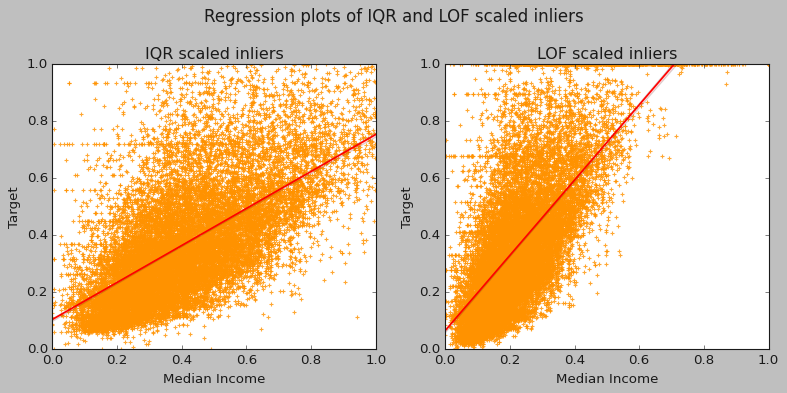

In [15]:
# -------------------------------- Correlation matrices --------------------------------
# Generate main figure
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Correlation matrices of IQR and LOF scaled inliers", fontsize=15)

# Generate IQR correlation matrix
correlation_iqr = inliers_iqr_scaled.corr()
matrix_iqr = ax[0].matshow(correlation_iqr)
plt.colorbar(matrix_iqr, ax=ax[0], fraction=0.045, pad=0.05)
ax[0].set_title("IQR scaled inliers", y=-0.1)

# Generate LOF correlation matrix
correlation_lof = inliers_lof_scaled.corr()
matrix_lof = ax[1].matshow(correlation_lof)
plt.colorbar(matrix_lof, ax=ax[1], fraction=0.045, pad=0.05)
ax[1].set_title("LOF scaled inliers", y=-0.1)

# Add ticks
for i in range(2):
    ax[i].set_xticks(range(len(correlation_iqr.columns)))
    ax[i].set_yticks(range(len(correlation_iqr.columns)))
    ax[i].set_xticklabels(correlation_iqr.columns)
    ax[i].set_yticklabels(correlation_iqr.columns)
    plt.setp(ax[i].get_xticklabels(), rotation="vertical")

# Tweak style (optional)
plt.tight_layout()

# -------------------------------- Regression plots --------------------------------
# Generate main figure
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Regression plots of IQR and LOF scaled inliers", fontsize=15)

# Generate IQR regression plot
sns.regplot(x=inliers_iqr_scaled["MedInc"],
            y=inliers_iqr_scaled["Target"],
            ax=ax[0],
            marker="+",
            color=sns.color_palette("autumn")[3],
            line_kws={"color": "red"})
ax[0].set_xlabel("Median Income")
ax[0].set_title("IQR scaled inliers")
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)

# Generate LOF regression plot
sns.regplot(x=inliers_lof_scaled["MedInc"],
            y=inliers_lof_scaled["Target"],
            ax=ax[1],
            marker="+",
            color=sns.color_palette("autumn")[3],
            line_kws={"color": "red"})
ax[1].set_xlabel("Median Income")
ax[1].set_title("LOF scaled inliers")
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)

# Tweak style (optional)
plt.tight_layout()

## Closed-form equations
Simple linear regression can be described by only two parameters: slope $m$ and intercept $b$

$$\hat{y} = mx + b$$

Estimated as

$$m = \frac{\sum_{i=0}^n(x_i-\overline{x})(y_i-\overline{y})}{\sum_{i=0}^n(x_i-\overline{x})^2}$$
$$b = y-mx$$

In the general case of $\textit{m}$ features, we would call it multiple linear regression, and we could no longer use formulas above, but instead the linear function will be defined as:

$$y=m_0x_0 + m_1x_1 + ... + m_mx_m = \sum_{j=0}^m\textbf{m}^T\textbf{x}$$

Here y is the response variable, $\textbf{x}$ is an m-dimensional sample vector, and $\textbf{w}$ is the weight vector (vector of coefficients, or slopes as defined before). 

Note that $m_0$ represents the y-axis intercept of the model and therefore $m_0=1$. Using the closed-form solution (normal equation), we compute the weights of the model as follows:

$$\textbf{m} = (\textbf{X}^T\textbf{X})^{-1}\textbf{X}^Ty$$

### Simple linear regression: custom implementation

In [16]:
class SimpleLinearRegression:
    def fit(self, X, y):
        self.X = X
        self.y = y
        self.m = ((np.mean(X) * np.mean(y) - np.mean(X * y)) /
                  ((np.mean(X)**2) - np.mean(X**2)))
        self.b = np.mean(y) - self.m * np.mean(X)

    def coeffs(self):
        return self.m, self.b

    def predict(self, X):
        self.y_pred = self.m * X + self.b
        return self.y_pred

#### Train and test on different samples. Leverage train_test_split from sklearn.model_selection
Evaluate the results for:
- only inliers scaled
- original dataset

In [17]:
from sklearn.model_selection import train_test_split

# Get a simple linear regression object
lr = SimpleLinearRegression()

# Use IQR scaled inliers
X_iqr = inliers_iqr_scaled["MedInc"]
y_iqr = inliers_iqr_scaled["Target"]

# Get train and test subsets
X_train_iqr, X_test_iqr, y_train_iqr, y_test_iqr = train_test_split(X_iqr, y_iqr, test_size=0.33)

# Compute simple linear regression
lr.fit(X_train_iqr, y_iqr)
y_pred_iqr = lr.predict(X_test_iqr)

# Evaluate using mean squared error regression loss
mse_iqr = mean_squared_error(y_test_iqr, y_pred_iqr)
print("Mean of squared errors (IQR inliers): " + "{:.4f}".format(mse_iqr))

# Use LOF scaled inliers
X_lof = inliers_lof_scaled["MedInc"]
y_lof = inliers_lof_scaled["Target"]

# Get train and test subsets
X_train_lof, X_test_lof, y_train_lof, y_test_lof = train_test_split(X_lof, y_lof, test_size=0.33)

# Compute simple linear regression
lr.fit(X_train_lof, y_lof)
y_pred_lof = lr.predict(X_test_lof)

# Evaluate using mean squared error regression loss
mse_lof = mean_squared_error(y_test_lof, y_pred_lof)
print("Mean of squared errors (LOF inliers): " + "{:.4f}".format(mse_lof))

Mean of squared errors (IQR inliers): 0.0233
Mean of squared errors (LOF inliers): 0.0316


#### Make a scatterplot showing also the obtained linear regression line


c:\users\m.rossini\development\ai-and-ml-assignments\venv\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
c:\users\m.rossini\development\ai-and-ml-assignments\venv\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


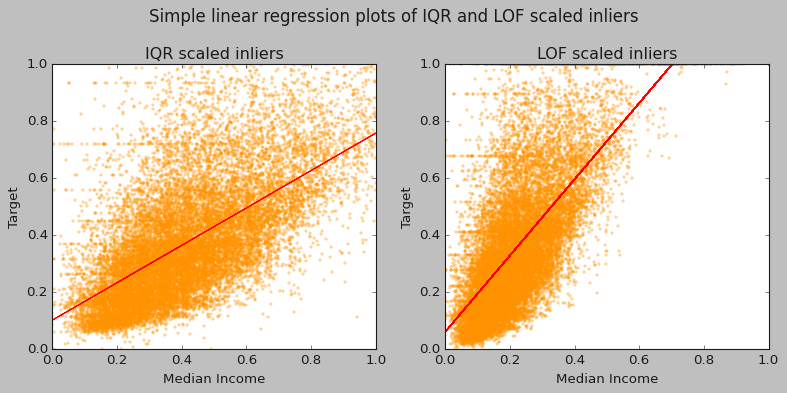

In [18]:
# Generate main figure
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle("Simple linear regression plots of IQR and LOF scaled inliers", fontsize=15)

# Generate IQR simple linear regression plot
sns.scatterplot(x=inliers_iqr_scaled["MedInc"],
            y=inliers_iqr_scaled["Target"],
            ax=ax[0],
            marker="+",
            color=sns.color_palette("autumn")[3])
ax[0].set_xlabel("Median Income")
ax[0].set_title("IQR scaled inliers")
ax[0].plot(X_test_iqr, y_pred_iqr, "red")
ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)

# Generate LOF simple linear regression plot
sns.scatterplot(x=inliers_lof_scaled["MedInc"],
            y=inliers_lof_scaled["Target"],
            ax=ax[1],
            marker="+",
            color=sns.color_palette("autumn")[3])
ax[1].set_xlabel("Median Income")
ax[1].set_title("LOF scaled inliers")
ax[1].plot(X_test_lof, y_pred_lof, "red")
ax[1].set_xlim(0, 1)
ax[1].set_ylim(0, 1)

# Tweak style (optional)
plt.tight_layout()

### Multiple Linear Regression with Least Squares: custom implementation

In [19]:
class MultipleLinearRegression:
    '''
    Multiple Linear Regression with Least Squares    
    '''
    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y)
        self.coeffs = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

    def predict(self, X):
        X = np.array(X)
        result = np.zeros(len(X))
        for i in range(X.shape[1]):
            result += X[:, i] * self.coeffs[i]
        return result

    def coeffs(self):
        return self.coeffs

#### Train and test on different samples. Leverage train_test_split from sklearn.model_selection
Evaluate the results for
- only inliers, scaled
- original dataset

In [20]:
from sklearn.model_selection import train_test_split

# Get a multiple linear regression object
mlr = MultipleLinearRegression()

# Use IQR scaled inliers
X_iqr = inliers_iqr_scaled.values[:, 0:-1]
y_iqr = inliers_iqr_scaled.values[:, -1]

# Get train and test subsets
X_train_iqr, X_test_iqr, y_train_iqr, y_test_iqr = train_test_split(X_iqr, y_iqr, test_size=0.33)

# Compute multiple linear regression
mlr.fit(X_train_iqr, y_train_iqr)
y_pred_iqr = mlr.predict(X_test_iqr)

# Evaluate using mean squared error regression loss
mse_iqr = mean_squared_error(y_test_iqr, y_pred_iqr)
print("Mean of squared errors (IQR inliers): " + "{:.4f}".format(mse_iqr))

# Use LOF scaled inliers
X_lof = inliers_lof_scaled.values[:, 0:-1]
y_lof = inliers_lof_scaled.values[:, -1]

# Get train and test subsets
X_train_lof, X_test_lof, y_train_lof, y_test_lof = train_test_split(X_lof, y_lof, test_size=0.33)

# Compute multiple linear regression
mlr.fit(X_train_lof, y_train_lof)
y_pred_lof = mlr.predict(X_test_lof)

# Evaluate using mean squared error regression loss
mse_lof = mean_squared_error(y_test_lof, y_pred_lof)
print("Mean of squared errors (LOF inliers): " + "{:.4f}".format(mse_lof))

Mean of squared errors (IQR inliers): 0.0198
Mean of squared errors (LOF inliers): 0.0606


## Gradient Descent
The idea behind gradient descent is simple - by gradually tuning parameters, such as slope (m) and the intercept (b) in our regression function y = mx + b, we minimize a **cost**. By **cost**, we usually mean some kind of a function that tells us how far off our model predicted result. For regression problems we often use mean squared error (MSE) cost function. If we use gradient descent for the classification problem, we will have a different set of parameters to tune.

$$ MSE = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y_i})^2 \quad \textrm{where} \quad \hat{y_i} = mx_i + b $$

We use <u>partial derivatives</u> to find how each individual parameter affects MSE. Hence, we take the derivative with respect to m and b separately. 

To derive with respect to $m$ we will use chain rule.
$$𝑓(𝑚,𝑏)= \frac{1}{n}\sum_{i=1}^{n}(y_i - (mx_i+b))^2$$

$$[f(g(x))]' = f'(g(x)) * g(x)'$$

$$ (y - (mx + b))^2 $$


1. Derivative of $()^2$ is $2()$
2. We do nothing with $y - (mx + b)$
3. Derivative of $y - (mx + b)$ with respect to $m$ is $-x$

Partical derivative with respect to $b$

Same rules apply to the derivative with respect to $b$.

1. $()^2$ becomes $2()$
2. $y - (mx + b)$ stays the same
3. $y - (mx + b)$ is $-1$

Hence:

$$\frac{\partial f}{\partial m} = \frac{1}{n}\sum_{i=1}^{n}-2x_i(y_i - (mx_i+b))$$
$$\frac{\partial f}{\partial b} = \frac{1}{n}\sum_{i=1}^{n}-2(y_i - (mx_i+b))$$

In [21]:
def gradient_descent(X, y, lr=0.05, epoch=10):
    '''
    Gradient Descent for a single feature
    '''
    # Parameters
    m, b = 0.2, 0.2
    # lists to store learning process
    log, mse = [], []
    # Number of samples
    N = len(X)

    for _ in range(epoch):
        f = y - (m * X + b)

        # Update m and b
        m -= lr * (-2 * X.dot(f).sum() / N)
        b -= lr * (-2 * f.sum() / N)

        log.append((m, b))
        mse.append(mean_squared_error(y, (m * X + b)))

    return m, b, log, mse

In [22]:
from sklearn.model_selection import train_test_split

# Use IQR scaled inliers
X_iqr = inliers_iqr_scaled["MedInc"]
y_iqr = inliers_iqr_scaled["Target"]

# Get train and test subsets
X_train_iqr, X_test_iqr, y_train_iqr, y_test_iqr = train_test_split(X_iqr, y_iqr, test_size=0.33)

# Compute gradient descent
m_iqr, b_iqr, log_iqr, mse_list_iqr = gradient_descent(X_train_iqr, y_train_iqr, lr=0.05, epoch=100)
y_pred_iqr = m_iqr * X_test_iqr + b_iqr

# Evaluate using mean squared error regression loss
mse_iqr = mean_squared_error(y_test_iqr, y_pred_iqr)
print("Mean of squared errors (IQR inliers): " + "{:.4f}".format(mse_iqr))

# Use LOF scaled inliers
X_lof = inliers_lof_scaled["MedInc"]
y_lof = inliers_lof_scaled["Target"]

# Get train and test subsets
X_train_lof, X_test_lof, y_train_lof, y_test_lof = train_test_split(X_lof, y_lof, test_size=0.33)

# Compute gradient descent
m_lof, b_lof, log_lof, mse_list_lof = gradient_descent(X_train_lof, y_train_lof, lr=0.05, epoch=100)
y_pred_lof = m_lof * X_test_lof + b_lof

# Evaluate using mean squared error regression loss
mse_lof = mean_squared_error(y_test_lof, y_pred_lof)
print("Mean of squared errors (LOF inliers): " + "{:.4f}".format(mse_lof))

Mean of squared errors (IQR inliers): 0.0275
Mean of squared errors (LOF inliers): 0.0462


#### Make a scatter plot and a plot showing the MSE

c:\users\m.rossini\development\ai-and-ml-assignments\venv\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
c:\users\m.rossini\development\ai-and-ml-assignments\venv\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


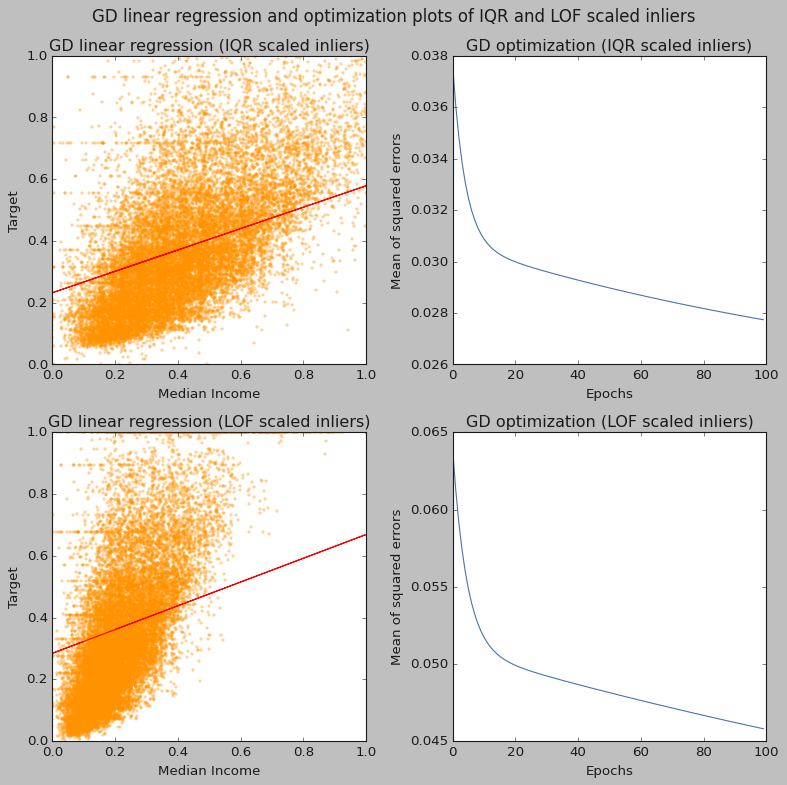

In [23]:
# Generate main figure
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(
    "GD linear regression and optimization plots of IQR and LOF scaled inliers",
    fontsize=15)

# Generate IQR GD linear regression plot
sns.scatterplot(x=inliers_iqr_scaled["MedInc"],
                y=inliers_iqr_scaled["Target"],
                ax=ax[0][0],
                marker="+",
                color=sns.color_palette("autumn")[3])
ax[0][0].set_xlabel("Median Income")
ax[0][0].set_title("GD linear regression (IQR scaled inliers)")
ax[0][0].plot(X_test_iqr, y_pred_iqr, "red")
ax[0][0].set_xlim(0, 1)
ax[0][0].set_ylim(0, 1)

# Generate IQR GD optimization plot
ax[0][1].plot(range(len(mse_list_iqr)), mse_list_iqr)
ax[0][1].set_xlabel("Epochs")
ax[0][1].set_ylabel("Mean of squared errors")
ax[0][1].set_title("GD optimization (IQR scaled inliers)")

# Generate LOF GD linear regression plot
sns.scatterplot(x=inliers_lof_scaled["MedInc"],
                y=inliers_lof_scaled["Target"],
                ax=ax[1][0],
                marker="+",
                color=sns.color_palette("autumn")[3])
ax[1][0].set_xlabel("Median Income")
ax[1][0].set_title("GD linear regression (LOF scaled inliers)")
ax[1][0].plot(X_test_lof, y_pred_lof, "red")
ax[1][0].set_xlim(0, 1)
ax[1][0].set_ylim(0, 1)

# Generate LOF GD optimization plot
ax[1][1].plot(range(len(mse_list_lof)), mse_list_lof)
ax[1][1].set_xlabel("Epochs")
ax[1][1].set_ylabel("Mean of squared errors")
ax[1][1].set_title("GD optimization (LOF scaled inliers)")

# Tweak style (optional)
plt.tight_layout()

## Stochastic Gradient Descent 

Stochastic Gradient Descent (SGD) works almost the same as Gradient Descent (also called Batch Gradient Descent), but instead of training on entire dataset, it picks only a batch of samples (at least one) to update m and b parameters, which makes it much faster.

In [24]:
def SGD(X, y, lr=0.05, epoch=10, batch_size=10):
    '''
    Stochastic Gradient Descent for a single feature
    '''
    # Initial parameters
    m, b = 0.5, 0.5
    # Lists to store learning process
    log, mse = [], []

    for _ in range(epoch):
        # Random sample
        indexes = np.random.randint(0, len(X), batch_size)

        Xs = np.take(X, indexes)
        ys = np.take(y, indexes)
        N = len(Xs)

        f = ys - (m * Xs + b)

        # Update parameters m and b
        m -= lr * (-2 * Xs.dot(f).sum() / N)
        b -= lr * (-2 * f.sum() / N)

        log.append((m, b))
        mse.append(mean_squared_error(y, m * X + b))

    return m, b, log, mse

In [25]:
from sklearn.model_selection import train_test_split

# Use IQR scaled inliers
X_iqr = inliers_iqr_scaled["MedInc"]
y_iqr = inliers_iqr_scaled["Target"]

# Get train and test subsets
X_train_iqr, X_test_iqr, y_train_iqr, y_test_iqr = train_test_split(X_iqr, y_iqr, test_size=0.33)

# Compute stochastic gradient descent
m_iqr, b_iqr, log_iqr, mse_list_iqr = SGD(X_train_iqr, y_train_iqr, lr=0.01, epoch=100, batch_size=10)
y_pred_iqr = m_iqr * X_test_iqr + b_iqr

# Evaluate using mean squared error regression loss
mse_iqr = mean_squared_error(y_test_iqr, y_pred_iqr)
print("Mean of squared errors (IQR inliers): " + "{:.4f}".format(mse_iqr))

# Use LOF scaled inliers
X_lof = inliers_lof_scaled["MedInc"]
y_lof = inliers_lof_scaled["Target"]

# Get train and test subsets
X_train_lof, X_test_lof, y_train_lof, y_test_lof = train_test_split(X_lof, y_lof, test_size=0.33)

# Compute stochastic gradient descent
m_lof, b_lof, log_lof, mse_list_lof = SGD(X_train_lof, y_train_lof, lr=0.01, epoch=100, batch_size=10)
y_pred_lof = m_lof * X_test_lof + b_lof

# Evaluate using mean squared error regression loss
mse_lof = mean_squared_error(y_test_lof, y_pred_lof)
print("Mean of squared errors (LOF inliers): " + "{:.4f}".format(mse_lof))

Mean of squared errors (IQR inliers): 0.0277
Mean of squared errors (LOF inliers): 0.0444


c:\users\m.rossini\development\ai-and-ml-assignments\venv\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)
c:\users\m.rossini\development\ai-and-ml-assignments\venv\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  points = ax.scatter(*args, **kws)


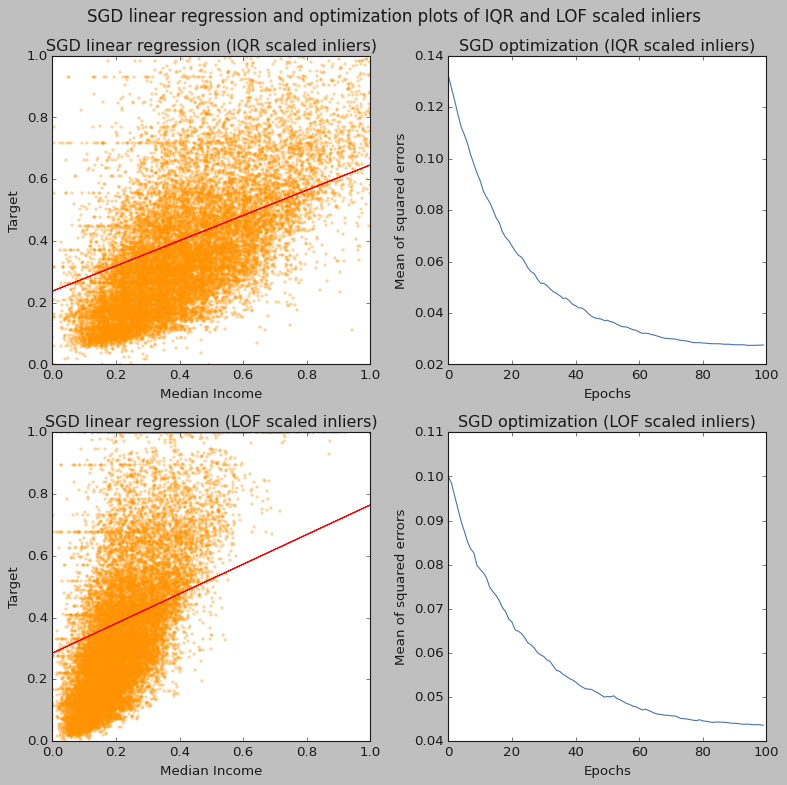

In [26]:
# Generate main figure
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle(
    "SGD linear regression and optimization plots of IQR and LOF scaled inliers",
    fontsize=15)

# Generate IQR SGD linear regression plot
sns.scatterplot(x=inliers_iqr_scaled["MedInc"],
                y=inliers_iqr_scaled["Target"],
                ax=ax[0][0],
                marker="+",
                color=sns.color_palette("autumn")[3])
ax[0][0].set_xlabel("Median Income")
ax[0][0].set_title("SGD linear regression (IQR scaled inliers)")
ax[0][0].plot(X_test_iqr, y_pred_iqr, "red")
ax[0][0].set_xlim(0, 1)
ax[0][0].set_ylim(0, 1)

# Generate IQR SGD optimization plot
ax[0][1].plot(range(len(mse_list_iqr)), mse_list_iqr)
ax[0][1].set_xlabel("Epochs")
ax[0][1].set_ylabel("Mean of squared errors")
ax[0][1].set_title("SGD optimization (IQR scaled inliers)")

# Generate LOF SGD linear regression plot
sns.scatterplot(x=inliers_lof_scaled["MedInc"],
                y=inliers_lof_scaled["Target"],
                ax=ax[1][0],
                marker="+",
                color=sns.color_palette("autumn")[3])
ax[1][0].set_xlabel("Median Income")
ax[1][0].set_title("SGD linear regression (LOF scaled inliers)")
ax[1][0].plot(X_test_lof, y_pred_lof, "red")
ax[1][0].set_xlim(0, 1)
ax[1][0].set_ylim(0, 1)

# Generate LOF SGD optimization plot
ax[1][1].plot(range(len(mse_list_lof)), mse_list_lof)
ax[1][1].set_xlabel("Epochs")
ax[1][1].set_ylabel("Mean of squared errors")
ax[1][1].set_title("SGD optimization (LOF scaled inliers)")

# Tweak style (optional)
plt.tight_layout()

## Speed Test for Gradient Descent vs SGD

In [27]:
%timeit gradient_descent(X_train_iqr, y_train_iqr, lr=0.01, epoch=100)

117 ms ± 2.04 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [28]:
%timeit gradient_descent(X_train_lof, y_train_lof, lr=0.01, epoch=100)

119 ms ± 4.77 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [29]:
%timeit SGD(X_train_iqr, y_train_iqr, lr=0.01, epoch=100, batch_size=1)

277 ms ± 87 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
%timeit SGD(X_train_lof, y_train_lof, lr=0.01, epoch=100, batch_size=1)

279 ms ± 116 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
